In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [10]:
time_config = [
    (1,0.0,1600,0),
    (1,0.1,1200,0),
    (1,0.1,600,0),
    (1,0.2,1000,0),
    (1,0.2,800,0),
    (1,0.3,800,0),
    (1,0.5,800,0),
    (1,0.3,600,0),
    (2,0.1,800,200),
    (2,0.2,500,100),
    (3,0.2,500,200),
    (3,0.4,500,200),
    (3,0.2,400,100),
    (3,0.4,400,200),
    (3,0.4,400,100),
    (3,0.2,300,0),
    (3,0.3,300,100),
]
components = [2,3,5,8,10]
freqs = [2.,7.,18.,35.,60.,70.,90.,110.,120.,130,140]
freq_tags = ['7','18','35','60','70','90','110','120','130','140Hz']

In [11]:
time_config = [
    (1,0.0,1600,0),
    (1,0.2,1200,0),
    (1,0.2,800,0),
    (1,0.4,800,0),
    (1,0.4,600,0),
    (1,0.4,400,0),
    (3,0.2,500,200),
    (3,0.4,500,200),
    (3,0.2,400,100),
    (3,0.4,400,200),
    (3,0.4,400,100),
    (3,0.2,300,0),
    (3,0.4,300,100),
]
components = [2,4,6,8,10]

In [12]:
directory = os.fsencode(os.path.abspath(os.getcwd()))
left_right_scores = []
for dr in os.listdir(directory):
    if os.path.isdir(dr) :
        for file in os.listdir(dr):
            if 'scores_1_left_right' in str(file) :
                scr = np.load(str(dr).split("'")[1]+'/'+str(file).split("'")[1])
                left_right_scores.append(scr[:,0:5,:])

In [9]:
subjets = np.array(left_right_scores).shape[0]
scores = np.concatenate(left_right_scores,axis=2)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_13488\815522863.py:23: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_val = scs[scs['freqs']==sample_name].median()[0]


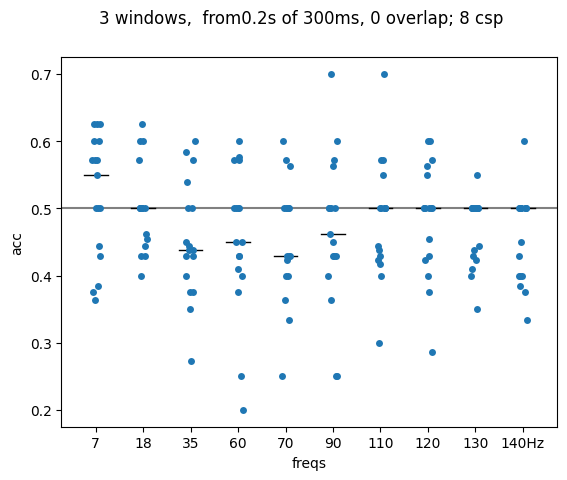

In [8]:
i = 0
for cmp in components:
    j = 0
    for cnf in time_config:
        n_windows, t_min, width, overlap = cnf
        scores_df = pd.DataFrame(
            data = scores[j,i].reshape(subjets,len(freq_tags)),
            columns = freq_tags)
        accuracies = []
        freqs = []
        if len(np.where(np.array(scores_df.median()) > 0.5)[0]) > 0:
            for col in scores_df.columns:
                accuracies = np.concatenate((accuracies, scores_df[col].values))
                freqs += [col] * len(scores_df[col])
            scs = pd.DataFrame(data=list(zip(accuracies,freqs)), columns=['acc','freqs'])
            csp_fig, axes = plt.subplots(1)
            csp_fig.suptitle('{} windows,  from{}s of {}ms, {} overlap; {} csp'.format(n_windows,t_min,width,overlap,cmp))
            axes.axhline(.5, c='grey')
            sns.stripplot(y='acc', x='freqs', data=scs, ax=axes)
            median_width= 0.5
            for tick, text in zip(axes.get_xticks(), axes.get_xticklabels()):
                sample_name = text.get_text()  # "X" or "Y"
                median_val = scs[scs['freqs']==sample_name].median()[0]
                axes.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                        lw=1, color='k')
        j+= 1
    i+=1

In [13]:
left_rest_scores = []
for dr in os.listdir(directory):
    if os.path.isdir(dr) :
        for file in os.listdir(dr):
            if 'scores_1_left_right' in str(file) :
                scr = np.load(str(dr).split("'")[1]+'/'+str(file).split("'")[1])
                left_rest_scores.append(scr)

In [14]:
medians = []
i = 0
for cnf in time_config:
    j = 0
    median = []
    for cmp in components:
        data = np.apply_along_axis(np.median, 0 ,scores[i,j].reshape(subjets,len(freq_tags)))
        median.append(data)
        j += 1
    medians.append(median)
    i += 1

In [45]:
np.array(medians[0]).shape

(5, 10)

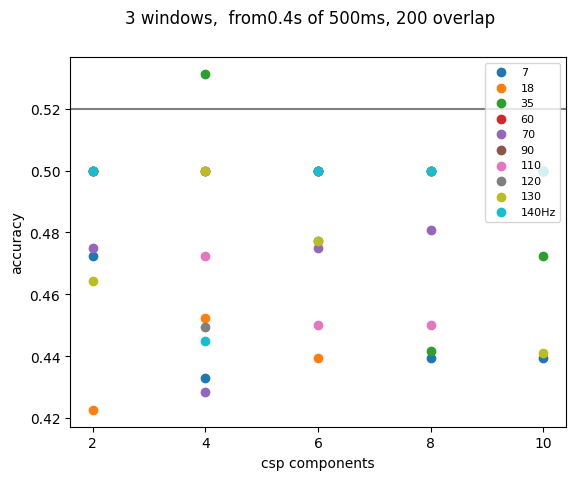

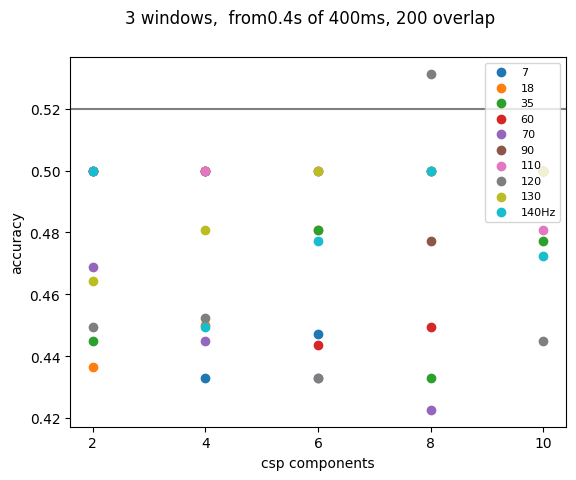

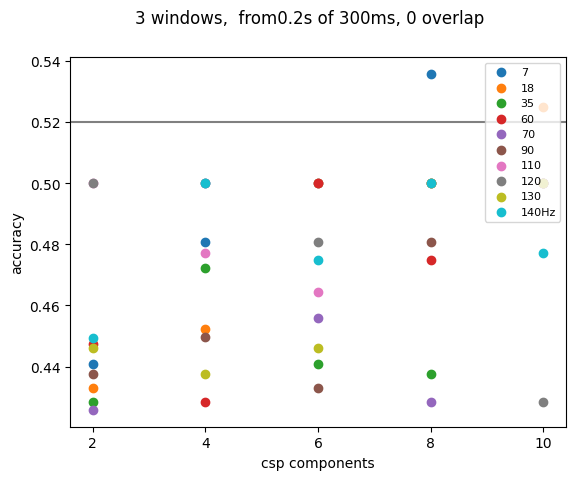

In [25]:
components = [2,4,6,8,10]
i=0
for cnf in medians: 
    n_windows, t_min, width, overlap = time_config[i]
    if np.max(cnf) > 0.53:
        csp_fig, axes = plt.subplots(1)
        csp_fig.suptitle('{} windows,  from{}s of {}ms, {} overlap'.format(n_windows,t_min,width,overlap))
        for f,freq in enumerate(freq_tags):
            axes.scatter(components, np.array(cnf)[:,f])
        axes.axhline(.52, c='grey')
        axes.legend(freq_tags, loc='upper right', prop={'size':8})
        axes.set_xticks([2,4,6,8,10])
        axes.set_xlabel('csp components')
        axes.set_ylabel('accuracy')
    i+=1